# Space Invaders with Deep Q-Networks

In this notebook I will try to create a DQN that surpasses human ability in playing Space Invaders.
Lets see how it goes...

In [ ]:
#!pip install ale-py
#!pip install torch

In [3]:
import torch
print("CUDA" if torch.cuda.is_available() else "cpu")

CUDA


## SCORING in Space invaders 

The SPACE INVADERS are worth 5, 10, 15, 20, 25, 30 points in
the first through sixth rows respectively. (See diagram.) The
point value of each target stays the same as it drops lower on
the screen. Each complete set of SPACE INVADERS is worth 630
points.


taken from https://atariage.com/manual_html_page.php?SoftwareLabelID=460

In [ ]:
import logging
import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo
import ale_py
import random
import math
import numpy as np
from collections import defaultdict

gym.register_envs(ale_py)

# Training configuration
training_period = 250           # Record video every 250 episodes
num_training_episodes = 5_000  # Total training episodes
env_name = "ALE/SpaceInvaders-v5" # has a default obs tpye of rgb, 4 frames are skipped and the repeat action propability is 0.25

# Set up logging for episode statistics
logging.basicConfig(level=logging.INFO, format='%(message)s')

# Create environment with periodic video recording
# possible to activate full action space with full_action_space=True
# using grayscaling to reduce input of Q-Network
env = gym.make(env_name, render_mode="rgb_array", obs_type="grayscale")

# Record videos periodically (every 250 episodes)
env = RecordVideo(
    env,
    video_folder="space_invaders",
    name_prefix="training",
    episode_trigger=lambda x: x % training_period == 0  # Only record every 250th episode
)

# Track statistics for every episode (lightweight)
env = RecordEpisodeStatistics(env)

print(f"Training for {num_training_episodes} episodes")
print(f"Videos will be recorded every {training_period} episodes")
print(f"Videos saved to: space_invaders/")


Training for 5000 episodes
Videos will be recorded every 250 episodes
Videos saved to: space_invaders/


/home/f4zination/development/DQN-SpaceInvaders/.venv/lib/python3.13/site-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /home/f4zination/development/DQN-SpaceInvaders/space_invaders folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [24]:
print(env.action_space.n)

6


In [26]:
import torch.nn as nn


class QNetwork():

    def __init__(
        self,
        in_channels,
        action_space
        ):
        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=8, stride=4 ),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2, stride=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=2, stride=1),
            nn.Flatten(),
        )

        dummy = torch.zeros(1, in_channels, 210, 160)
        dummy_out = self.conv_stack(dummy)
        self.num_features = dummy_out.numel()

        self.fc = nn.Sequential(
            nn.Linear(self.num_features, 1024),
            nn.ReLU(),
            nn.Linear(1024, action_space)
        )

        self.model = self.conv_stack.extend(self.fc)


    def forward(self, input):
        return self.model(input)




In [ ]:

class SpaceInvaderAgent:

    def __init__(
        self,
        env: gym.Env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
        frame_stacking: int = 4,
    ):
        self.env = env
        
        # Q-Network for 
        self.target_network = QNetwork(in_channels=4, action_space=env.action_space.n)

        self.learning_network = QNetwork(in_channels=4, action_space=env.action_space.n)

        self.lr = learning_rate
        self.discount_factor = discount_factor  # How much we care about future rewards also known as gamma

        # Exploration parameters
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        # Track learning progress
        self.training_error = []

    # currently using a random action
    def get_action(self, obs: tuple[int, int, bool])-> int:
        # With probability epsilon: explore (random action)
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()

        # With probability (1-epsilon): exploit (best known action)
        else:
            return int(np.argmax(self.q_values[obs]))

        
    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Update Q-value based on experience.

        This is the heart of Q-learning: learn from (state, action, reward, next_state)
        """
        # What's the best we could do from the next state?
        # (Zero if episode terminated - no future rewards possible)
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])

        # What should the Q-value be? (Bellman equation)
        target = reward + self.discount_factor * future_q_value

        # How wrong was our current estimate?
        temporal_difference = target - self.q_values[obs][action]

        # Update our estimate in the direction of the error
        # Learning rate controls how big steps we take
        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )

        # Track learning progress (useful for debugging)
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        """Reduce exploration rate after each episode."""
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

    

    


In [13]:
# Training hyperparameters
learning_rate = 0.01        # How fast to learn (higher = faster but less stable)
n_episodes = 100_000        # Number of hands to practice
start_epsilon = 1.0         # Start with 100% random actions
epsilon_decay = start_epsilon / (n_episodes / 2)  # Reduce exploration over time
final_epsilon = 0.1         # Always keep some exploration


agent = SpaceInvaderAgent(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [14]:
from tqdm import tqdm  # Progress bar

for episode in tqdm(range(n_episodes)):
    # Start a new hand
    obs, info = env.reset()
    done = False

    # Play one complete hand
    while not done:
        # Agent chooses action (initially random, gradually more intelligent)
        action = agent.get_action(obs)

        # Take action and observe result
        next_obs, reward, terminated, truncated, info = env.step(action)

        # Learn from this experience
        agent.update(obs, action, reward, terminated, next_obs)

        # Move to next state
        done = terminated or truncated
        obs = next_obs

    # Reduce exploration rate (agent becomes less random over time)
    agent.decay_epsilon()

  0%|          | 0/100000 [00:00<?, ?it/s]


TypeError: unhashable type: 'numpy.ndarray'

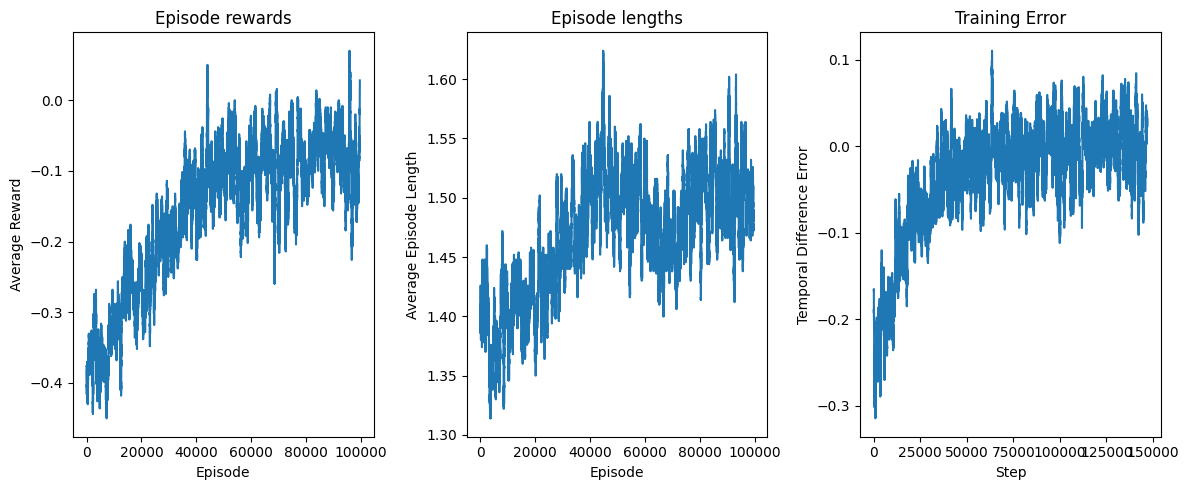

In [9]:
from matplotlib import pyplot as plt

def get_moving_avgs(arr, window, convolution_mode):
    """Compute moving average to smooth noisy data."""
    return np.convolve(
        np.array(arr).flatten(),
        np.ones(window),
        mode=convolution_mode
    ) / window

# Smooth over a 500-episode window
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))

# Episode rewards (win/loss performance)
axs[0].set_title("Episode rewards")
reward_moving_average = get_moving_avgs(
    env.return_queue,
    rolling_length,
    "valid"
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[0].set_ylabel("Average Reward")
axs[0].set_xlabel("Episode")

# Episode lengths (how many actions per hand)
axs[1].set_title("Episode lengths")
length_moving_average = get_moving_avgs(
    env.length_queue,
    rolling_length,
    "valid"
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[1].set_ylabel("Average Episode Length")
axs[1].set_xlabel("Episode")

# Training error (how much we're still learning)
axs[2].set_title("Training Error")
training_error_moving_average = get_moving_avgs(
    agent.training_error,
    rolling_length,
    "same"
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
axs[2].set_ylabel("Temporal Difference Error")
axs[2].set_xlabel("Step")

plt.tight_layout()
plt.show()